### Подготовка моделей

__Цель:__
- Прогнозировать целевую переменную prod_t -- время затрачиваемое на изготовление изделия (в минутах)
    - в качестве метрики r2_score

__Задачи__:
- На основе выводов предыдущего анализа подготовить признаки
- Привести данные к обучаемому виду (кодирование)
- Подготовить несколько моделей для сравнения
    - Попробовать традиционные регрессии (Линейные)
    - Дерево / Ансамбли
    - pytorch регрессия
    
__Структура:__
- [Подготовка данных](#data_processing)
- [Ансамбли](#ensemble)
- [Многослойная сеть. PyTorch](#pytorch)
- [Комментарии](#resume)

In [1]:
# # Часть проекта вынесена в библиотеки
# ! wget https://storage.yandexcloud.net/www.eugenegantz.ru/box/jknznqhakzo/index.zip
# ! unzip -qq index.zip

In [2]:
import math
import json
import pandas as pd
import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn import metrics
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from IPython.display import display
from IPython.display import clear_output

In [3]:
# общие утилиты
import lib.utils as utils

# утилиты для работы с товарной номенклатурой
import lib.gands as gands

# утилиты для обработки данных
import lib.data_processing as data_utils

<a id="data_processing"></a>
### Подготовка данных

In [4]:
GLOBAL_RANDOM_STATE = 128
Y_TARGETS = ['prod_t', 'sum']
Y1_TARGET = Y_TARGETS[0]
Y2_TARGET = Y_TARGETS[1]
Y_TARGET = Y1_TARGET

In [5]:
# импортировать данные подготовленные из учетной системы
def _import_data_from_file(filepath, filter_func=utils.stubTrue):
    f = open(filepath, 'r', encoding='utf-8')
    train = json.loads(''.join(f.readlines()))

    rows = []
    props = dict()

    for row in train:
        for k in row:
            props[k] = 1

    for row in train:
        _row = dict()

        for k in props:
            _row[k] = row.get(k, '')

        if filter_func(_row):
            rows.append(_row)

    return pd.DataFrame(rows)

In [6]:
# словарь номенклатуры
gsref = gands.GSRef('./data/gands/gands.json')

In [7]:
# Все изделия
df_all = _import_data_from_file('./data/crm/train.json')

In [8]:
df = df_all.copy()

Думаю, необходимо расчитать prod_load заранее  
Логичнее учитывать нагрузку на все производство

In [9]:
df = data_utils.df_calc_prod_load(df, inplace=True)
df = data_utils.df_add_weekday(df, 'gsdate_ts', 'weekday')

Пытаться обучить модель на всех данных для всех изделий, думаю, пока преждевременно.  
Выбрать самое популярное изделие (баннеры)

In [10]:
df = df[df['gsid'] == 'ГПШрПЛ']

df

,mmid,gs,prod_t,sum,user_groups,gsdate_ts,gsdate2_ts,userId,gsid,post_id,...,вид значка,тип коробки,размер коробки,цвет ленты,цвет нанесения,способ упаковки,макет основы,добавить цепочку,prod_load,weekday
29,1470947,ГПШрПЛ01,5540.0,130.0,7,1.641481e+09,1.641814e+09,12.237896,ГПШрПЛ,22,...,,,,,,,,,194817.233333,4
63,1471394,ГПШрПЛ01,8680.0,900.0,7,1.641382e+09,1.641903e+09,12.219142,ГПШрПЛ,22,...,,,,,,,,,84556.683333,3
69,1477282,ГПШрПЛ07,5601.0,234.0,3,1.641471e+09,1.641807e+09,12.259561,ГПШрПЛ,22,...,,,,,,,,,182622.850000,4
70,1477286,ГПШрПЛ07,5601.0,160.0,3,1.641471e+09,1.641807e+09,12.259561,ГПШрПЛ,22,...,,,,,,,,,188223.200000,4
71,1477290,ГПШрПЛ07,5600.0,160.0,3,1.641471e+09,1.641807e+09,12.259561,ГПШрПЛ,22,...,,,,,,,,,193823.833333,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10222,1641001,ГПШрПЛ01,4987.0,284.0,7,1.659039e+09,1.659338e+09,12.223701,ГПШрПЛ,22,...,,,,,,,,,319598.983333,4
10224,1641014,ГПШрПЛ02,4462.0,2544.0,7,1.659096e+09,1.659364e+09,12.223701,ГПШрПЛ,22,...,,,,,,,,,254136.033333,5
10225,1641212,ГПШрПЛ01,4261.0,781.0,7,1.659081e+09,1.659336e+09,12.242964,ГПШрПЛ,22,...,,,,,,,,,253846.533333,5
10226,1641446,ГПШрПЛ02,157.0,140.0,3,1.659092e+09,1.659101e+09,12.263176,ГПШрПЛ,22,...,,,,,,,,,245435.633333,5


In [11]:
data_utils.remove_empty_columns(df, inplace=True, print_dropped_columns=False)

,mmid,gs,prod_t,sum,user_groups,gsdate_ts,gsdate2_ts,userId,__источник,материал,...,цвет пленки для порезки,выборка порезки,монтажная пленка,порезка на отдельные изделия,разрезать на блоки,размер блока,загрузите макет,двойной проход печати,prod_load,weekday
29,1470947,ГПШрПЛ01,5540.0,130.0,7,1.641481e+09,1.641814e+09,12.237896,ма,ТЦШКОЖ04,...,,,,,,,,,194817.233333,4
63,1471394,ГПШрПЛ01,8680.0,900.0,7,1.641382e+09,1.641903e+09,12.219142,ма,ТЦШКОЖ04,...,,,,,Добавить,А3,,,84556.683333,3
69,1477282,ГПШрПЛ07,5601.0,234.0,3,1.641471e+09,1.641807e+09,12.259561,ма,ТЦШК0504,...,,,,,,,,,182622.850000,4
70,1477286,ГПШрПЛ07,5601.0,160.0,3,1.641471e+09,1.641807e+09,12.259561,ма,ТЦШК0504,...,,,,,,,,,188223.200000,4
71,1477290,ГПШрПЛ07,5600.0,160.0,3,1.641471e+09,1.641807e+09,12.259561,ма,ТЦШК0504,...,,,,,,,,,193823.833333,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10222,1641001,ГПШрПЛ01,4987.0,284.0,7,1.659039e+09,1.659338e+09,12.223701,ма,ТЦШКОЖ04,...,,,,,,,,,319598.983333,4
10224,1641014,ГПШрПЛ02,4462.0,2544.0,7,1.659096e+09,1.659364e+09,12.223701,ма,ТЦШКОЖ14,...,,,,,,,,Добавить,254136.033333,5
10225,1641212,ГПШрПЛ01,4261.0,781.0,7,1.659081e+09,1.659336e+09,12.242964,ма,ТЦШКОЖ04,...,,,,,,,,,253846.533333,5
10226,1641446,ГПШрПЛ02,157.0,140.0,3,1.659092e+09,1.659101e+09,12.263176,ма,ТЦШКОЖ14,...,,,,,,,,,245435.633333,5


In [12]:
df.shape

(2374, 28)

Значения в таблице не однородны,
иногда числовые поля по замыслу или по ошибке могут содержать строки или коды номенклатуры

Подсчитать статистику типов по каждому полю.
Принять, что поле относится к тому типу данных, доля которого в общем подсчете свыше 90%

Привести поле к подсчитанному типу

- коды номенклатуры -- category
- прочий текст -- category, str
- остальное -- числа: int64, float64


Реализация `DFTypeCaster`
```
./lib/data_processing.py
```

In [13]:
tcaster = data_utils.DFTypeCaster(gsref)

df = tcaster.auto_type_cast_df(df)

df.dtypes

mmid                               int64
gs                              category
prod_t                             int64
sum                              float64
user_groups                        int64
gsdate_ts                          int64
gsdate2_ts                         int64
userId                           float64
__источник                      category
материал                        category
тираж                            float64
длина,м                          float64
ширина,м                         float64
способ печати                   category
контурная порезка на рулоне     category
макет                           category
ламинация                       category
тип пленки                      category
цвет пленки для порезки         category
выборка порезки                 category
монтажная пленка                category
порезка на отдельные изделия    category
разрезать на блоки              category
размер блока                    category
загрузите макет 

In [14]:
for c in df.columns:
    print('\n------------')
    print('column: ', c)
    print('dtype: ', df[c].dtype)
    print('unique: ', df[c].unique()[-15:])


------------
column:  mmid
dtype:  int64
unique:  [1640375 1640503 1640616 1640631 1640881 1640885 1640889 1640893 1640971
 1640976 1641001 1641014 1641212 1641446 1641490]

------------
column:  gs
dtype:  category
unique:  ['ГПШрПЛ01', 'ГПШрПЛ07', 'ГПШрПЛ02', 'ГПШрПЛ14', 'ГПШрПЛ09', 'ГПШрПЛ13', 'ГПШрПЛ11', 'ГПШрПЛ05', 'ГППЛПО']
Categories (9, object): ['ГППЛПО', 'ГПШрПЛ01', 'ГПШрПЛ02', 'ГПШрПЛ05', ..., 'ГПШрПЛ09', 'ГПШрПЛ11', 'ГПШрПЛ13', 'ГПШрПЛ14']

------------
column:  prod_t
dtype:  int64
unique:  [1712 1682 1903 8301 5611 5594 5750 5667 3282 1326 4994 4993 4987 4462
 6873]

------------
column:  sum
dtype:  float64
unique:  [8244.    318.    162.96  686.    328.    137.    770.    920.   5620.
  765.    210.   1007.   2573.    223.   2544.  ]

------------
column:  user_groups
dtype:  int64
unique:  [7 3 1]

------------
column:  gsdate_ts
dtype:  int64
unique:  [1658998519 1659000842 1659000670 1659007099 1659003445 1659008353
 1659166200 1659013212 1659268821 1659038561 16590

<AxesSubplot:>

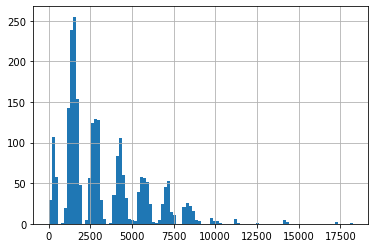

In [15]:
df['prod_t'].hist(bins=100)

In [16]:
# Попробовать очистить выборку от выбросов (IQR)
df = df.loc[data_utils.f_remove_outlier_iqr(df[Y_TARGET]).index]

<AxesSubplot:>

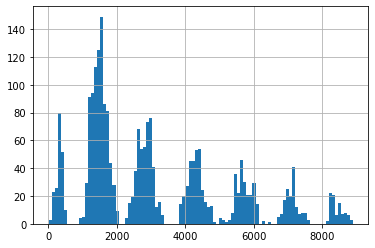

In [17]:
df['prod_t'].hist(bins=100)

In [18]:
# отбросить поля с nan корреляцией
def f():
    # Категориальные признаки в числовые
    _df = data_utils.df_cat_to_int(df)
    ycorr = _df.corr()[Y_TARGET]
    
    columns_to_drop = []

    for c in ycorr.index:            
        if math.isnan(ycorr[c]):
            print('dropped:', c, ycorr[c])
            columns_to_drop.append(c)

    df.drop(columns=columns_to_drop, inplace=True)
    
    print(df.shape)
f()

(2337, 28)


Подготовить данные к обучению:
- унитарное кодирование (onehot-encoding): post_id, gs, gsid, user_groups, weekday
- удалить поля: mmid, userId, sum, gsdate_ts, gsdate2_ts
- кодирование в числа категориальных признаков

In [19]:
def _create_train_dataset(df: pd.DataFrame, print_debug=False) -> np.ndarray:
    onehot_cols = [
        'post_id',
        'gs',
        'gsid',
        'user_groups',
        'weekday',
#         'способ печати',
#         'контурная порезка на рулоне',
#         'ламинация',
#         'выборка порезки',
#         'порезка на отдельные изделия',
#         'разрезать на блоки',
#         'двойной проход печати',
    ]

    onehot_cols = [c for c in onehot_cols if c in df]
    
    drop_cols   = Y_TARGETS + ['mmid', 'userId', 'sum', 'gsdate2_ts', 'gsdate_ts']
    drop_cols   = [c for c in drop_cols if c in df]
    
    y_cols      = [c for c in [Y_TARGET] if c in df]

    df = df.copy()
    
    y = df[y_cols].values
    
    # Исключить целевую переменную из выборки
    df.drop(columns=drop_cols, inplace=True)
    
    # Привести категориальные признаки в числовые
    data_utils.df_cat_to_ord_enc(df, inplace=True)
    
    # Унитарное-кодирование (onehot-encoding)
    data_utils.df_col_to_onehot_enc(df, cols=onehot_cols, inplace=True)
    
    if print_debug:
        display(df.columns)

    x = df.values
    
    scaler = StandardScaler()
    # scaler = MinMaxScaler([0, 1])
    
    x = scaler.fit_transform(x)
    
    if print_debug:
        print('y_cols:', y_cols)
        print('drop_cols:', drop_cols)
        print('onehot_cols:', onehot_cols)
    
    return x, y

In [20]:
x_data, y_data = _create_train_dataset(df, print_debug=True)

Index(['__источник', 'материал', 'тираж', 'длина,м', 'ширина,м',
       'способ печати', 'контурная порезка на рулоне', 'макет', 'ламинация',
       'тип пленки', 'цвет пленки для порезки', 'выборка порезки',
       'монтажная пленка', 'порезка на отдельные изделия',
       'разрезать на блоки', 'размер блока', 'загрузите макет',
       'двойной проход печати', 'prod_load', '_enc_gs_0', '_enc_gs_1',
       '_enc_gs_2', '_enc_gs_3', '_enc_gs_4', '_enc_gs_5', '_enc_gs_6',
       '_enc_gs_7', '_enc_gs_8', '_enc_user_groups_1', '_enc_user_groups_3',
       '_enc_user_groups_7', '_enc_weekday_1', '_enc_weekday_2',
       '_enc_weekday_3', '_enc_weekday_4', '_enc_weekday_5', '_enc_weekday_6',
       '_enc_weekday_7'],
      dtype='object')

y_cols: ['prod_t']
drop_cols: ['prod_t', 'sum', 'mmid', 'userId', 'sum', 'gsdate2_ts', 'gsdate_ts']
onehot_cols: ['gs', 'user_groups', 'weekday']


In [21]:
display(x_data[0:5], y_data[0:5])

array([[-1.17825563e-01, -1.45264672e-01, -1.77610780e-01,
        -1.52881614e-01, -5.20213207e-01,  1.65199698e+00,
        -6.03550499e-01, -6.55543942e-02, -6.70284754e-01,
        -3.22627018e-01, -2.06901472e-02, -2.16894008e-01,
        -1.28564869e-01, -4.33709247e-01, -6.55543942e-02,
        -6.21770004e-02, -2.06901472e-02, -1.79565632e-01,
        -2.26533241e+00, -2.06901472e-02,  4.95047395e-01,
        -3.43775825e-01, -3.58517370e-02, -2.61891400e-01,
        -1.06068567e-01, -6.21770004e-02, -8.56013213e-02,
        -5.48114208e-02, -4.38573755e-01, -4.39267105e-01,
         6.90828484e-01, -4.86993347e-01, -4.78908104e-01,
        -5.08410682e-01,  1.79824794e+00, -4.29523717e-01,
        -7.18421208e-02, -1.40119620e-01],
       [-1.17825563e-01, -1.45264672e-01,  1.24620204e-02,
        -9.37906534e-01, -9.17884378e-01,  5.16825869e-01,
         1.65686219e+00, -6.55543942e-02,  7.61575822e-01,
        -3.22627018e-01, -2.06901472e-02, -2.16894008e-01,
        -1.28

array([[5540],
       [8680],
       [5601],
       [5601],
       [5600]], dtype=int64)

In [22]:
x_train, x_test, y_train, y_test = train_test_split(
    x_data,
    y_data,
    test_size=0.1,
    random_state=GLOBAL_RANDOM_STATE,
    shuffle=True,
)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2103, 38), (2103, 1), (234, 38), (234, 1))

<a id="ensemble"></a>
### Ансамбли

In [23]:
def _regression_gscv(
    estimator,
    dataset,
    param_grid={},
    print_predictions=False,
    print_scores=False,
    verbose=False,
):
    x_train, y_train, x_test, y_test = dataset
    
    rs = GLOBAL_RANDOM_STATE

    cv = KFold(n_splits=10, shuffle=True, random_state=rs)

    gscv = GridSearchCV(
        estimator=estimator,
        cv=cv,
        param_grid=param_grid,
        scoring='r2',
        verbose=verbose,
    )
    
    gscv.fit(x_train, y_train)
    
    p = gscv.predict(x_test)

    for i, _ in enumerate(p):
        if p[i] < 0:
            p[i] = 1

    r2_score = metrics.r2_score(y_test, p)
    mse_score = metrics.mean_squared_error(y_test, p)
    msle_score = metrics.mean_squared_log_error(y_test, p)
    
    return {
        'gscv': gscv,
        'scores': {
            'r2_score': r2_score,
            'mse_score': mse_score,
            'msle_score': msle_score,   
        },
    }
#/def

In [24]:
def _iterate_test_cases(tests, dataset):    
    _report = []
    _best_estimator = None
    _best_score = 0
    
    for test in tests:
        reg = test['ctor']()
        
        _res = _regression_gscv(
            estimator=reg,
            param_grid=test['param_grid'],
            dataset=dataset,
            verbose=3,
        )
        
        if _res['scores']['r2_score'] > _best_score:
            _best_score = _res['scores']['r2_score']
            _best_estimator = _res['gscv'].best_estimator_
        
        _report.append({
            'name': test['name'],
            'r2': round(_res['scores']['r2_score'], 2),
            'mse': round(_res['scores']['mse_score']),
            'gscv_best_params_': str(_res['gscv'].best_params_),
            'gscv_best_score_': _res['gscv'].best_score_,   
        })
        
        
    return {
        'best_estimator': _best_estimator,
        'report': _report,
    }
#/def

In [25]:
def f():
    global _report
    global _best_estimator
    
    rs = GLOBAL_RANDOM_STATE
    
    x = x_train
    y = y_train.astype('int64').ravel()
    
    xt = x_test
    yt = y_test.astype('int64').ravel()

    tests = [
        {
            'name': 'LinearRegression',
            'ctor': LinearRegression,
            'param_grid': {},
        },
        {
            'name': 'GradientBoostingRegressor',
            'ctor': GradientBoostingRegressor,
            'param_grid': {
                'n_estimators': [100, 500, 1000],
                'random_state': [rs],
            }
        },
        {
            'name': 'BaggingRegressor',
            'ctor': BaggingRegressor,
            'param_grid': {
                'base_estimator': [None, LinearRegression()],
                'random_state': [rs],
            },
        },
        {
            'name': 'AdaBoostRegressor',
            'ctor': AdaBoostRegressor,
            'param_grid': {
                'base_estimator': [None, LinearRegression(), ExtraTreeRegressor()],
            },
        },
        {
            'name': 'RandomForestRegressor',
            'ctor': RandomForestRegressor,
            'param_grid': {
                'n_estimators': [1000]
            },
        },
    ];
    
    dataset = (x, y, xt, yt)
    
    _ = _iterate_test_cases(tests, dataset)
    
    _best_estimator = _['best_estimator']
    _report = _['report']
f()

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END .................................., score=0.229 total time=   0.0s
[CV 2/10] END .................................., score=0.299 total time=   0.0s
[CV 3/10] END .................................., score=0.196 total time=   0.0s
[CV 4/10] END .................................., score=0.154 total time=   0.0s
[CV 5/10] END .................................., score=0.200 total time=   0.0s
[CV 6/10] END ......., score=-136142140995788534538305536.000 total time=   0.0s
[CV 7/10] END .................................., score=0.194 total time=   0.0s
[CV 8/10] END .................................., score=0.320 total time=   0.0s
[CV 9/10] END .................................., score=0.199 total time=   0.0s
[CV 10/10] END ................................., score=0.065 total time=   0.0s
Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV 1/10] END n_estimators=100, random_state=128;, score=0.332 total

[CV 3/10] END ................n_estimators=1000;, score=0.424 total time=   7.8s
[CV 4/10] END ................n_estimators=1000;, score=0.497 total time=   7.7s
[CV 5/10] END ................n_estimators=1000;, score=0.492 total time=   7.6s
[CV 6/10] END ................n_estimators=1000;, score=0.544 total time=   7.7s
[CV 7/10] END ................n_estimators=1000;, score=0.494 total time=   7.7s
[CV 8/10] END ................n_estimators=1000;, score=0.523 total time=   7.7s
[CV 9/10] END ................n_estimators=1000;, score=0.407 total time=   7.8s
[CV 10/10] END ...............n_estimators=1000;, score=0.341 total time=   7.5s


In [26]:
if False:
    f = open('./reports/train_report.json', 'w', encoding='utf-8')
    f.write(json.dumps(_report))
    
if False:
    f = open('./reports/train_report.json', 'r', encoding='utf-8')
    _report = json.loads(''.join(f.readlines()))

In [27]:
pd.DataFrame(_report)

,name,r2,mse,gscv_best_params_,gscv_best_score_
0,LinearRegression,0.21,3736593,{},-1.361421e+25
1,GradientBoostingRegressor,0.33,3158266,"{'n_estimators': 500, 'random_state': 128}",3.802516e-01
2,BaggingRegressor,0.33,3154409,"{'base_estimator': None, 'random_state': 128}",4.412766e-01
3,AdaBoostRegressor,0.29,3357604,{'base_estimator': ExtraTreeRegressor()},4.329392e-01
4,RandomForestRegressor,0.37,3005570,{'n_estimators': 1000},4.855216e-01


In [28]:
def f():
    xt = x_test
    yt = y_test.astype('int64').ravel()

    p = _best_estimator.predict(xt)
    
    _print = []

    for i, _ in enumerate(p):
        if p[i] < 0 or yt[i] < 0:
            p[i] = 1
            yt[i] = 1
        
        if i < 25:
            _print.append({
                'p'          : p[i],
                'y'          : yt[i],
                'abs(y - p)' : abs(p[i] - yt[i]),
                '(y / p)'    : yt[i] / p[i]
            })
            
    r2_score = metrics.r2_score(yt, p)
    mse_score = metrics.mean_squared_error(yt, p)
    msle_score = metrics.mean_squared_log_error(yt, p)
    
    print(_best_estimator)
    print('r2_score = ' + str(r2_score))
    print('mse_score = ' + str(mse_score))
    print('msle_score = ' + str(msle_score))
            
    display(pd.DataFrame(_print))
f()

RandomForestRegressor(n_estimators=1000)
r2_score = 0.3654127888549964
mse_score = 3005569.8310689
msle_score = 0.5786569011171654


,p,y,abs(y - p),(y / p)
0,2409.448000,1640,769.448000,0.680654
1,2812.362000,489,2323.362000,0.173875
2,4845.055750,5444,598.944250,1.123620
3,2603.011000,1490,1113.011000,0.572414
4,4118.645850,8323,4204.354150,2.020810
5,2983.452741,1253,1730.452741,0.419983
6,3619.213000,1405,2214.213000,0.388206
7,5466.134000,5735,268.866000,1.049188
8,2435.964000,1777,658.964000,0.729485
9,2464.576000,1283,1181.576000,0.520576


Не смотря на то, что это существенно лучше, чем первоначальный прогноз калькулятора (r2=-0.5), но это всеравно очень низкий уровень качества прогнозирования.

Расхождение в 1000 минут и свыше.

Я ожидал лучшего прогноза.

<a id="pytorch"></a>
### Многослойная сеть. PyTorch

В построении модели прогноза срока производства изделия лежит такая логика, что каждое отдельное свойство продукции (ламинация, лак, порезка и др.) является соответствующей внутрипроизводственной задачей.  
Таким образом, срок производства конечного изделия будет линейной комбинацией сроков работ из которого изделие состоит

```
способ_печати {a, b, c} => {1, 2, 3} => x1 * w1 = ...
+
ламинация     {да, нет} => {0, 1}    => x2 * w2 = ...
+
порезка       {да, нет} => {0, 1}    => x3 * w3 = ...
+
фольгирование {да, нет} => {0, 1}    => x4 * w4 = ...
+
...
+
прочее        {да, нет} => {0, 1}    => xn * wn = ...
```

In [29]:
#
# Многослойный перцептрон
# Регрессия -- обобщает в одномерный вектор (1 нейрон, скаляр)
#

class MLP(nn.Module):

    def __init__(self, input_features_size):
        super().__init__()

        f = input_features_size

#         params = [
#             f,                      # input  0
#             math.trunc(f * 0.75),   # hidden 1
#             math.trunc(f * 0.5),    # hidden 2
#             math.trunc(f * 0.25),   # hidden 3
#             1,                      # output 4
#         ]
        
        params = [
            f,        # input  0
            f * 4,    # hidden 1
            f * 2,    # hidden 2
            f,        # hidden 3
            1,        # output 4
        ]
        
        print(params)

        self.layers = nn.Sequential(
            nn.Linear(params[0], params[1]),
            nn.ReLU(),
            nn.Linear(params[1], params[2]),
            nn.ReLU(),
            nn.Linear(params[2], params[3]),
            nn.ReLU(),
            nn.Linear(params[3], params[4])
        )

    def forward(self, x):
        return self.layers(x)


In [30]:
global_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# display(torch.cuda.is_available())
# display(torch.cuda.current_device())
# display(torch.cuda.get_device_name(torch.cuda.current_device()))

global_device

device(type='cuda')

In [31]:
mlp = MLP(input_features_size=x_train.shape[1])

[38, 152, 76, 38, 1]


In [32]:
mlp.to(global_device)
display(next(mlp.parameters()).is_cuda)

True

In [33]:
def f_train_model(
    model,
    dataloader,
    optimizer,
    loss_function,
    epochs,
):
    torch.manual_seed(GLOBAL_RANDOM_STATE)

    for epoch in tqdm(range(0, epochs)):

        clear_output()
        
        if (epoch > 0):
            avg_loss = current_loss / len(dataloader)
            avg_loss = round(avg_loss, 3)
            print(f"avg_loss = {avg_loss}")

        current_loss = 0.0

        print(f'Starting epoch {epoch + 1} of {epochs}')

        for i, data in enumerate(tqdm(dataloader), 0):
            x, y = data
            x, y = x.to(global_device), y.to(global_device)
            x, y = x.float(), y.float()
            y = y.reshape((y.shape[0], 1))

            # print(inputs.shape, targets.shape)
            
            # Обнулить градиенты
            optimizer.zero_grad()

            # Вернуть прогноз
            p = model(x)

            # Вернуть ошибку (разница)
            loss = loss_function(p, y)

            # ?
            loss.backward()

            # ?
            optimizer.step()

            # Подсчитать статистику
            current_loss += loss.item()

    print('Training process has finished.')

In [34]:
def f():
    batch_size = 10
    epochs = 1000
    
    x = x_train
    y = y_train.astype('int64').ravel()
    
    tensor_x = torch.Tensor(x) # transform to torch tensor
    tensor_y = torch.Tensor(y)
    
    dataset = TensorDataset(tensor_x, tensor_y) # create your datset
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Define the loss function and optimizer
    # loss_function = nn.L1Loss()
    loss_function = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)
    
    f_train_model(
        model=mlp,
        dataloader=dataloader,
        optimizer=optimizer,
        loss_function=loss_function,
        epochs=epochs,
    )

f()

avg_loss = 1264211.237
Starting epoch 1000 of 1000


  0%|          | 0/211 [00:00<?, ?it/s]

Training process has finished.


In [35]:
# avg_loss ~= 31000 прогресс кажется остановился

# после применения StandartScaler разница очевидна
# скорость обучения возросла, средняя ошибка сущесвтенно уменьшилась
# epochs=1000
# avg_loss ~= 1477

In [36]:
def f_validate_model(
    model,
    dataloader,
):
    total_p = []
    total_y = []
    _print = []

    for j, data in enumerate(dataloader):
        x, y = data
        x, y = x.to(global_device), y.to(global_device)
        x, y = x.float(), y.float()
        y = y.reshape((y.shape[0], 1))

        # Вернуть прогноз
        p = model(x)

        np_p = p.cpu().detach().numpy()
        np_y = y.cpu().detach().numpy()

        for i, _ in enumerate(np_p):
            _p = np_p[i][0]
            _y = np_y[i][0]
            
            total_p.append(_p)
            total_y.append(_y)
            
            _print.append({
                'p'          : _p,
                'y'          : _y,
                'abs(y - p)' : abs(_p - _y),
                '(y / p)'    : _y / _p
            })
        #/for
    #/for
        
    display(metrics.r2_score(total_y, total_p))
    
    display(pd.DataFrame(_print[0:10]))

In [37]:
def _f():
    batch_size = 100
    
    xt = x_test
    yt = y_test.astype('int64').ravel()
    
    tensor_x = torch.Tensor(xt)
    tensor_y = torch.Tensor(yt)
    
    dataset = TensorDataset(tensor_x, tensor_y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    f_validate_model(
        model=mlp,
        dataloader=dataloader,
    )
    
_f()

-6.156136633211186

,p,y,abs(y - p),(y / p)
0,7466.233887,7249.0,217.233887,0.970904
1,5885.854492,5928.0,42.145508,1.007160
2,2017.034180,2590.0,572.965820,1.284063
3,4151.088379,7140.0,2988.911621,1.720031
4,6090.384277,7350.0,1259.615723,1.206820
5,4167.056152,489.0,3678.056152,0.117349
6,3255.144531,2988.0,267.144531,0.917932
7,843.510071,1427.0,583.489929,1.691740
8,6374.879883,4376.0,1998.879883,0.686444
9,3984.661133,7408.0,3423.338867,1.859129


<a id="resume"></a>
### Комментарии

Несмотря на то, что конечная цель была прогнозировать сроки производства для всех типов изделий, в качестве первого приближения была выбрана цель попроще. Потому все модели построены только для одного типа изделия: ГПШрПЛ01 (Широкоформатная пленка, Баннер).

Результаты неутешительные.  
Отобранная лучшая модель среди обученных, вернула результат по r2_score выше чем у калькулятора: 0.36 > -0.5.  
Но, несмотря на то, что это существенно лучше, чем первоначальный прогноз калькулятора, это всё равно очень низкий уровень прогнозирования.  
Расхождение в 1000 минут и свыше.

Аугментация данных в виде признаков "weekday", "prod_load", "user_groups" не привели к радикальному улучшению прогнозируемости. (их корреляция приведена в разделе "анализ")

Надежда на то, что срок производства конечного изделия будет линейной комбинацией сроков работ из которого изделие состоит, похоже, не оправдались. Унитарное кодирование (onehot-encoding) некоторых признаков лишь ухудшили результат:
- способ печати
- контурная порезка на рулоне
- ламинация
- выборка порезки
- порезка на отдельные изделия
- разрезать на блоки
- двойной проход печати

Модель регрессии на основе многослойного перцептрона показала себя еще хуже. Практически бесполезно.

Скорее всего, существуют какие-то необнаруженные мною скрытые параметры.

В перспективе имеет смысл попробовать отдельно прогнозировать сроки каждого этапа производства, а затем их суммировать.

Отдельно следует сказать про развертывание.

В данной конкретной работе развертывание модели мною не проводилось, но видно несколько проблем.  
Так как применительно к данной задаче не последним критерием является скорость обучения и переобучения, простота и доступность на разных платформах, то "старенькие" подходы к моделированию (линейная регрессия, деревья, бустинги) выглядят более привлекательными, чем современные (pytorch, tensorflow и тд). Именно за счет того, что обучение последних на полных данных может занять часы. В противовес вторым, первые переобучаются практически в считанные секунды.
К тому же, модели на pytorch требуют наличие реализации на целевой платформе (java, c++, nodejs и тд). И если готовой нет, то ее потребуется реализовывать своими силами. Гораздо проще это сделать для каких-нибудь деревьев.

Или если коротко:
- сроки обучения
    - количество признаков может меняться каждый день
    - кодирование признаков
        - значения признаков может меняться каждый день
- развертывание моделей 
    - новые библиотеки не всегда доступны на целевой платформе